In [30]:
import matplotlib.pyplot as plt
import numpy as np # useful for calculations
import h5py #required to read hdf5 files
import matplotlib as mpl
from tqdm import tqdm
from scipy import spatial

import pdb
FloatType = np.float64  # double precision: np.float64, for single use np.float32

def read_gadget_snapshot(file_name):
	data = h5py.File(file_name, 'r')  # load full hdf5 file

	time = FloatType(data['Header'].attrs['Time']) # the scale factor at which snapshot was written
	BoxSize = FloatType(data['Header'].attrs['BoxSize']) # box size in code units (Mpc)

	Pos = np.array(data['PartType1']['Coordinates'], dtype=FloatType) #3d Positions of all particles, e.g. x coord: Pos[:,0]

	mass = FloatType(data['Header'].attrs['MassTable'][1]) # mass of one DM particle

	n_particles = Pos.size // 3

	return time, Pos, mass, n_particles, BoxSize


file_name = "snapshot_002.hdf5"

time, Pos, mass, n_particles, BoxSize = read_gadget_snapshot(file_name)

print("Scale factor: %g  (should be 1)" %(time))

box_vol = BoxSize**3
mean_dist = (box_vol/n_particles)**(1/3)
print('mean distance between particles = {}'.format(mean_dist))


Scale factor: 1  (should be 1)
mean distance between particles = 0.3125


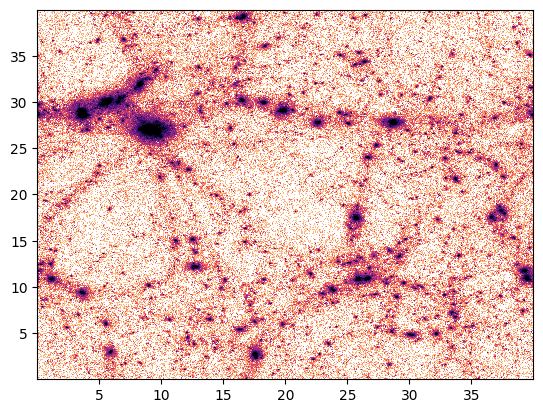

In [3]:
x=Pos[:, 0]
y=Pos[:, 1]
z=Pos[:, 2]

plt.hist2d(x, y, bins = 1000,  norm=mpl.colors.LogNorm(vmin=0.5, vmax=50), cmap = 'magma_r')
plt.show()

In [31]:
def particle_distance(i, j, positions):
    x_i, y_i, z_i = positions[i, 0], positions[i, 1], positions[i, 2]
    x_j, y_j, z_j = positions[j, 0], positions[j, 1], positions[j, 2]
    return np.sqrt((x_i - x_j)**2 + (y_i - y_j)**2 + (z_i - z_j)**2)

In [32]:
# friends of friends algorithm

# linking length:
linking_length = mean_dist*0.2
print('linking_length = ', linking_length)

# find friends:
all_particles = np.linspace(0, n_particles - 1, n_particles)
# all_particles = np.linspace(0, 9, 10)
lonely = all_particles
num_groups = 0
friend_dict = {}

for i in range(n_particles):  # Generates numbers from 0 to 10
    friend_dict[i] = []

# for i in tqdm(range(n_particles)):
#     print('on particle {}'.format(i))
#     # for j in tqdm(range(len(lonely))):
#     for j in range(i+1, n_particles): # vb changed to look at the upper triangle in the nxn particle matrix since it's symmetric ij vs ji, removed 2nd tqdm since would print 2 million times for each i

#         dist = particle_distance(i, j, Pos)
#         # print('potential neighbors {}'.format(j))
#         # print(dist)
#         # check if the particles are friends
#         if dist < linking_length:
#             friend_dict[i].append(j)
#             friend_dict[j].append(i)
#             # print('particle {} and {} are friends'.format(i, j))
#         else:
#             # particles are not friends
#             continue

linking_length =  0.0625


In [34]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.query_pairs.html
tree = spatial.cKDTree(Pos)
friend_pairs = tree.query_pairs(r=linking_length) # unique pairs of all points within linking length of one another

In [ ]:
for i, j in friend_pairs:
    friend_dict[i].append(j)
    friend_dict[j].append(i)
len(friend_pairs)

136815

In [42]:
"""
general idea:
    choose a 'lonely' particle and say it's part of a new halo
    take all its friends, and its friends' friends, and theirs, and so on, until there are no more friends to be added
    those particles together form the halo
    then find a new lonely particle and do the same thing
"""

lonely = np.ones(n_particles, dtype=bool)
print(lonely)
halos = []

for i in range(n_particles):
    if lonely[i]:
        lonely[i] = False
        halo = [i]
        halo.extend(friend_dict[i])
        for j in friend_dict[i]:
            halo.extend(friend_dict[j])
        halo = set(halo) # to get rid of duplicates
        if len(halo) > 1:
            halos.append(halo)
        TODO make this not just take friends and 2nd friends, but iterate until no more friends of friends to be added

SyntaxError: invalid decimal literal (2178802265.py, line 23)